In [1]:
dataset_path = "./dataset"

In [4]:
print(os.listdir(dataset_path))

['images']


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
%pip install scikit-learn seaborn

from tensorflow.keras import optimizers, models, layers, callbacks

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [6]:
base_dir = dataset_path + '/images'
train_dir = os.path.join(base_dir, 'train_new')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 240,
    
)
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 240,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (100, 100),
    batch_size = 8,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size= 8,
    class_mode='binary',
    shuffle = False
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (100, 100),
    batch_size = 8,
    class_mode = 'binary',
    shuffle = False
)

Found 1888 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

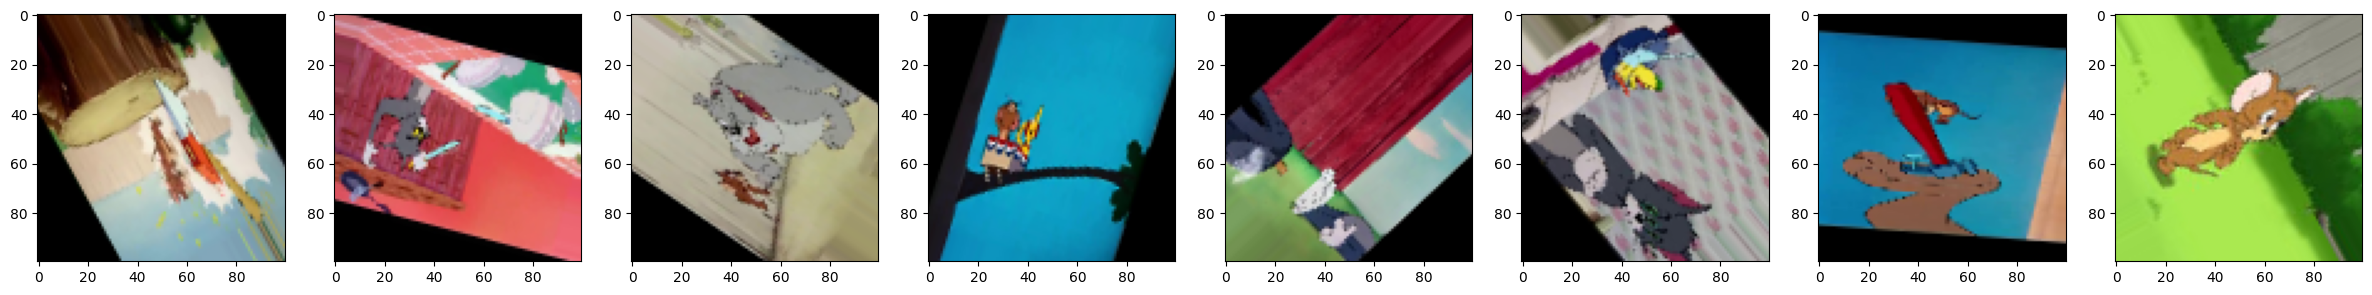

In [9]:
images, labels = train_generator[0]

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30,4))
for i in range(images.shape[0]):
    axarr[i].imshow(images[i])
plt.show()

In [10]:
def model_analysis(model, test_generator, class_0, class_1):
    predictions = model.predict(test_generator)
    predicted = (predictions > 0.5).astype(int).flatten()
    truth = test_generator.classes

    TP = TN = FP = FN = 0

    for i in range(len(truth)):
        if predicted[i] == 1:
            if truth[i] == 1:
                TP += 1
            else:
                FP += 1
        else: 
            if truth[i] == 0:
                TN += 1
            else:
                FN += 1

    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

    cmatrix = np.array([[TN, FP], [FN, TP]])
    class_names = [class_0, class_1]

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cmatrix, cmap='Blues')

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Real class')

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cmatrix[i, j], ha='center', va='center', color='black', fontsize=12)

    plt.title('Confusion Matrix')
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nPrecisión: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1_score:.3f}")


Improved model 

In [11]:
base_model_19 = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model_19.trainable = False

def get_model_19_compiled():

    model = models.Sequential([
        base_model_19,    
        layers.Flatten(),
        layers.Dense(512, activation='relu', name='dense_layer3'),
        layers.Dropout(0.2, name='dropout_3'),
        layers.Dense(256, activation='relu', name='dense_layer4'),
        layers.Dropout(0.4, name='dropout_4'),
        layers.Dense(256, activation='relu', name='dense_layer5'),
        layers.Dropout(0.8, name='dropout_5'),
        layers.Dense(1, activation='sigmoid', name='output')

    ])

    model.compile(
        optimizer=optimizers.RMSprop(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

improved_model = get_model_19_compiled()
improved_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 3, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer3 (Dense)            │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer4 (Dense)            │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer5 (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,581,569 (86.14 MB)

 Trainable params: 2,557,185 (9.75 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, test_generator, class_0, class_1):
        super().__init__()
        self.model_ref = model
        self.test_generator = test_generator
        self.test_acc = []
        self.test_loss = []
        self.class_0 = class_0
        self.class_1 = class_1

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_generator, verbose=0)
        self.test_acc.append(acc)
        self.test_loss.append(loss)

In [15]:
test_metrics_cb = TestMetricsCallback(improved_model, test_generator, 'Class 0', 'Class 1')

history_19 = improved_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                test_metrics_cb]
) 

Epoch 1/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5126 - loss: 0.7262

c:\Users\José Eduardo Díaz\Desktop\mini-proyectos\python\Image Classification\Saiyan_Classification_Model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


236/236 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.5126 - loss: 0.7262 - val_accuracy: 0.6500 - val_loss: 0.6715
Epoch 2/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - accuracy: 0.5726 - loss: 0.6948 - val_accuracy: 0.6639 - val_loss: 0.6644
Epoch 3/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - accuracy: 0.5760 - loss: 0.6915 - val_accuracy: 0.6750 - val_loss: 0.6578
Epoch 4/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 45s 190ms/step - accuracy: 0.5996 - loss: 0.6574 - val_accuracy: 0.6639 - val_loss: 0.6556
Epoch 5/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.5815 - loss: 0.6766 - val_accuracy: 0.6472 - val_loss: 0.6477
Epoch 6/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.6176 - loss: 0.6601 - val_accuracy: 0.6889 - val_loss: 0.6337
Epoch 7/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.6337 - loss: 0.6286 - val_accuracy: 0.7000 - val_loss: 0.6267
Epoch 8/15
236/236 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.6123 - loss: 0.6540 - val

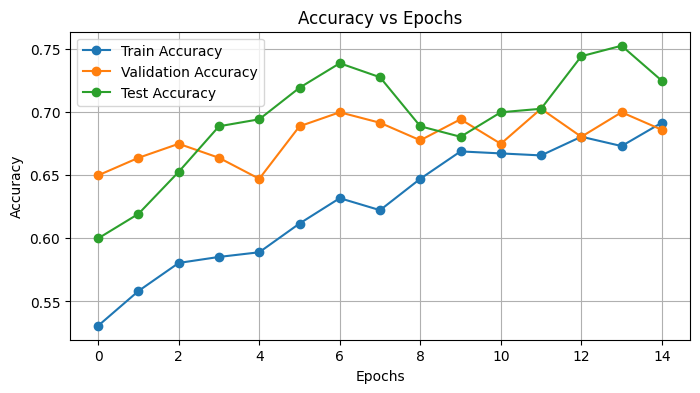

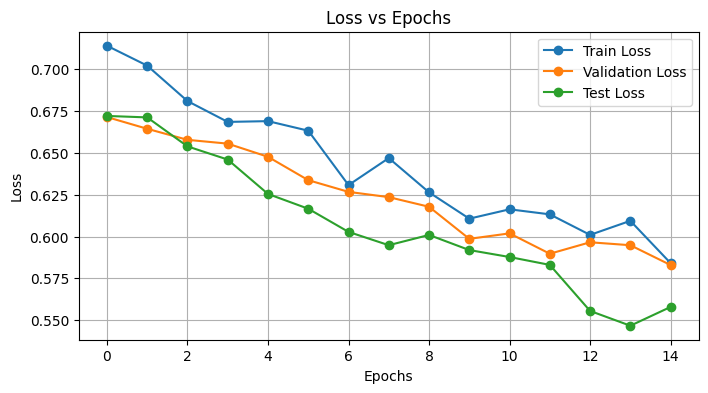

In [16]:
epochs = range(len(test_metrics_cb.test_loss))

plt.figure(figsize=(8, 4))
plt.plot(history_19.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_19.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(epochs, test_metrics_cb.test_acc, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss vs Epochs
plt.figure(figsize=(8, 4))
plt.plot(history_19.history['loss'], label='Train Loss', marker='o')
plt.plot(history_19.history['val_loss'], label='Validation Loss', marker='o')
plt.plot(epochs, test_metrics_cb.test_loss, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show() 

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.6889 - loss: 0.5770
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step


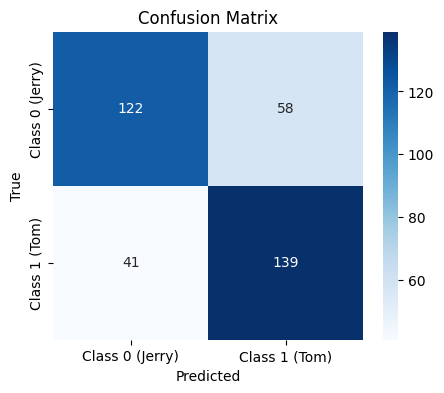

classification report
              precision    recall  f1-score   support

     Class 0       0.75      0.68      0.71       180
     Class 1       0.71      0.77      0.74       180

    accuracy                           0.72       360
   macro avg       0.73      0.73      0.72       360
weighted avg       0.73      0.72      0.72       360



In [18]:
test_generator.reset()
loss, acc = improved_model.evaluate(test_generator)

test_generator.reset()
y_pred = improved_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(test_generator.classes, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0 (Jerry)', 'Class 1 (Tom)'], 
            yticklabels=['Class 0 (Jerry)', 'Class 1 (Tom)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("classification report")
print(classification_report(test_generator.classes, y_pred_classes, target_names=['Class 0', 'Class 1']))

In [30]:
improved_model.save('improved_model_correction.h5')
improved_model = load_model('improved_model_correction.h5')


Improved model
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
TP: 100, TN: 83, FP: 97, FN: 80


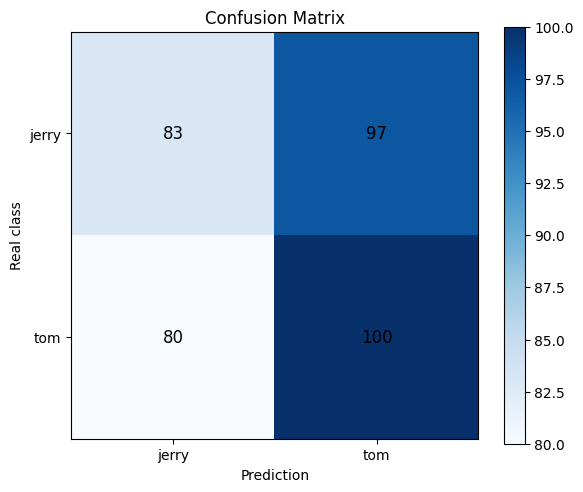


Precisión: 0.508
Recall: 0.556
F1-score: 0.531


In [31]:
classes_new = list(test_generator.class_indices.keys())

print("\nImproved model")
model_analysis(improved_model, test_generator, class_0=classes_new[0], class_1=classes_new[1])

In [56]:
def get_model_manual():

    model = models.Sequential([
        layers.Conv2D(200, (3, 3), activation='relu', input_shape=(100, 100, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.8),
        layers.Conv2D(400, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.6),
        layers.Conv2D(600, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Conv2D(800, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(1000, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.RMSprop(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model 

manual_model = get_model_manual()
manual_model.summary()


c:\Users\José Eduardo Díaz\Desktop\mini-proyectos\python\Image Classification\Saiyan_Classification_Model\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 98, 98, 200)    │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 49, 49, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 49, 49, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 47, 47, 400)    │       720,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 23, 23, 400)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 23, 23, 400)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 21, 21, 600)    │     2,160,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 10, 10, 600)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 10, 10, 600)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 800)      │     4,320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 800)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 4, 4, 800)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 2, 2, 1000)     │     7,201,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 1, 1, 1000)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1, 1, 1000)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,921,425 (56.92 MB)

 Trainable params: 14,921,425 (56.92 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
second_history = manual_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 115s 482ms/step - accuracy: 0.4705 - loss: 0.7511 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 117s 498ms/step - accuracy: 0.5130 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 120s 508ms/step - accuracy: 0.5156 - loss: 0.6925 - val_accuracy: 0.5361 - val_loss: 0.6920
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 115s 487ms/step - accuracy: 0.5183 - loss: 0.6927 - val_accuracy: 0.6028 - val_loss: 0.6919
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 114s 481ms/step - accuracy: 0.5844 - loss: 0.6790 - val_accuracy: 0.5417 - val_loss: 0.6945
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 115s 487ms/step - accuracy: 0.6213 - loss: 0.6581 - val_accuracy: 0.5194 - val_loss: 0.6973
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 115s 486ms/step - accuracy: 0.6640 - loss: 0.6145 - val_accuracy: 0.5333 - val_loss: 0.7636
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 114s 485ms/step - accuracy: 0.7418 -

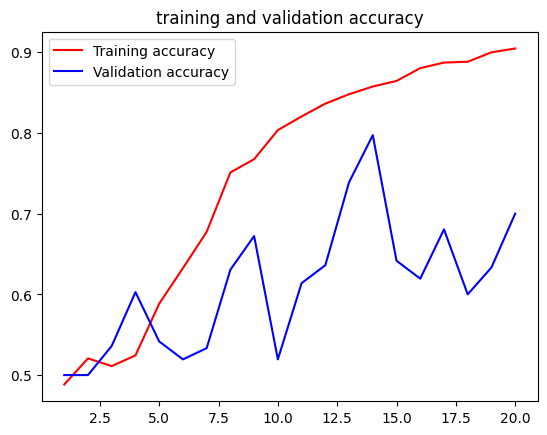

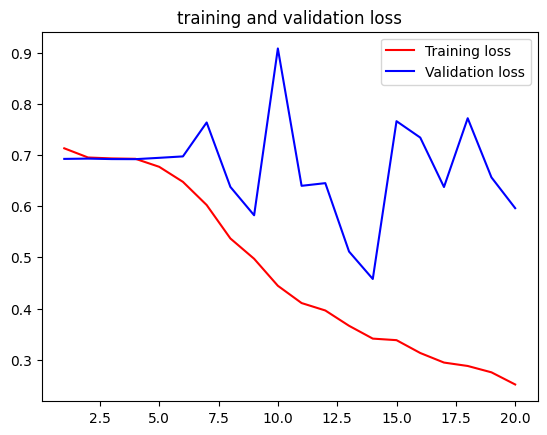

In [58]:
acc = second_history.history['accuracy']
val = second_history.history['val_accuracy']
loss = second_history.history['loss']
val_loss = second_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val, 'b', label='Validation accuracy')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()  

In [59]:
test_loss_manual, test_acc_manual = manual_model.evaluate(test_generator, steps = 25)
print('Test accuracy:', test_acc_manual)
print('Test loss:', test_loss_manual)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8603 - loss: 0.4774
Test accuracy: 0.8650000095367432
Test loss: 0.53896564245224


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
TP: 95, TN: 95, FP: 85, FN: 85


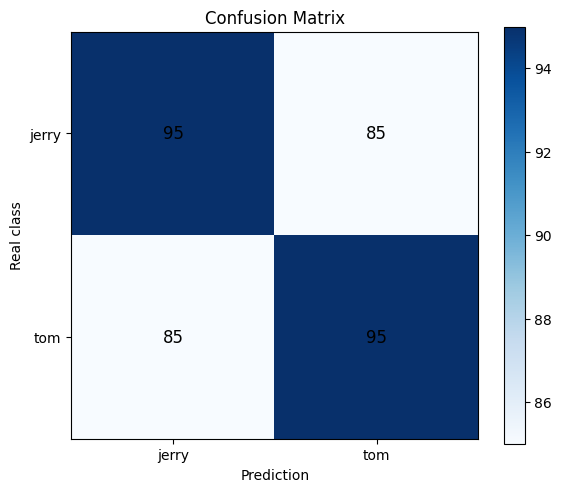


Precisión: 0.528
Recall: 0.528
F1-score: 0.528


In [60]:
model_analysis(manual_model, test_generator, class_0=classes_new[0], class_1=classes_new[1])

In [63]:
manual_model.save('manual_model.h5')
manual_model = load_model('manual_model.h5')

In [64]:
from tensorflow.keras.preprocessing import image

In [66]:
def interactive_prediction(model, img_path, target_size=(100, 100)):
    
    model = load_model(model)

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expand = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array_expand)[0][0]
    class_name = "Tom" if prediction > 0.5 else " Jerry"

    plt.imshow(img)
    plt.title(f"Predicted: {class_name} (Confidence: {prediction:.4f})")
    plt.axis('off')
    plt.show()

    return class_name

In [67]:
print(os.listdir('./dataset/images/interactive_test'))

['chapter04.pdf', 'test1.jfif', 'test10.png', 'test11.jpg', 'test13.png', 'test2.jfif', 'test3.jpg', 'test4.png', 'test5.jpg', 'test6.png', 'test7.jpg', 'test8.jpg', 'test9.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


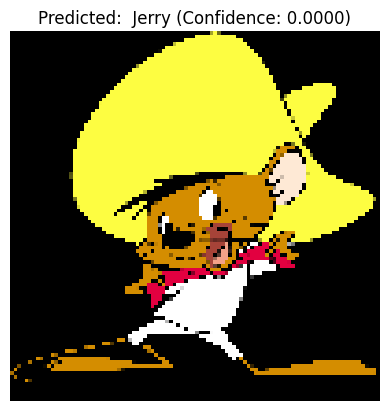

' Jerry'

In [81]:
interactive_prediction('manual_model.h5', './dataset/images/interactive_test/test13.png')
